In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn

from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# http://mathieu.delalandre.free.fr/projects/sesyd/symbols/floorplans.html
!wget -nc http://mathieu.delalandre.free.fr/projects/sesyd/symbols/floorplans/floorplans16-01.zip
!unzip -q -o -d data/ floorplans16-01.zip

DATA_DIR = 'data/'
print(os.listdir(DATA_DIR))

In [ ]:
image_size = 256
batch_size = 32
#stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
stats = (1, 1, 1), (1, 1, 1)

transform = tt.Compose([
    tt.Grayscale(num_output_channels=1),
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    # tt.Normalize(*stats),
    
])

train_ds = ImageFolder(DATA_DIR, transform = transform)

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 0, pin_memory = True)

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax = 64):
    fig, ax = plt.subplots(figsize = (8,8))
    ax.set_xticks([])
    ax.set_yticks([])
    denrom_batch = denorm(images.detach()[:nmax])
    grid = make_grid(denrom_batch, nrow = 8).permute(1,2,0)
    ax.imshow(grid)

def show_batch(dl, nmax = 64)    :
    for images, _ in dl:
        show_images(images, nmax)
        break

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device  = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)
    
        

In [ ]:
device = get_default_device()
device

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
first_kernel = image_size // 64
first_stride = first_kernel * 2
first_padding = first_kernel // 4
discriminator = nn.Sequential(
    #in: 3x64x64
    nn.Conv2d(1, 64, kernel_size = first_kernel, stride = first_stride, padding = first_padding, bias = False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace = True),
    #out: 64x32x32
    
    nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace = True),
    #out: 128x16x16
    
    nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace = True),
    #out: 256x8x8
    
    nn.Conv2d(256, 512, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace = True),
    #out: 512x4x4
    
    nn.Conv2d(512, 1, kernel_size = 4, stride = 1, padding = 0, bias = False),
    
    #out: 1x1x1
    
    nn.Flatten(),
    nn.Sigmoid()
)

In [ ]:
# test output shape of discriminator
print (first_kernel, first_stride, first_padding)
for real_images, _ in tqdm(train_dl):
    print (real_images.shape)
    d = discriminator(real_images)
    print(d.shape)
    break

In [ ]:
latent_size = 64

In [ ]:
gk = image_size // 64
gs = gk * 2
gp = gk 

generator = nn.Sequential(
    #in: latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 512, kernel_size = 4, stride = 1, padding = 0, bias = False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    #out: 512x4x4
    
    nn.ConvTranspose2d(512, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    #out: 256x8x8
    
    nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    #out: 128x16x16
    
    nn.ConvTranspose2d(128, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    #out: 64x32x32

    # https://pytorch.org/docs/master/generated/torch.nn.ConvTranspose2d.html
    nn.ConvTranspose2d(64, 1, kernel_size= gk, stride= gs, padding= 0, output_padding=gp, bias = False),
    nn.Tanh()
    #out: 3 x image_size x image_size
)

generator = to_device(generator, device)

4 8 4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 1, 256, 256])
torch.Size([32, 1])


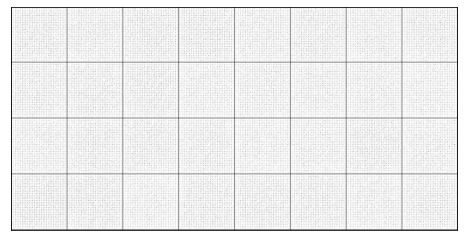

In [55]:
print (gk, gs, gp)
latent = torch.randn(batch_size, latent_size, 1, 1, device = device)
fake_images = generator(latent)
print(fake_images.shape)
show_images(fake_images)

fake_preds = discriminator(fake_images)
print(fake_preds.shape)

In [56]:
def train_discriminator(real_images, opt_d):
    # clear grad
    opt_d.zero_grad()
    
    # pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device = device)

    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device = device)
    fake_images = generator(latent)
    
    # pass fake images through discriminator
    fake_targetes = torch.zeros(fake_images.size(0), 1, device = device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targetes)
    fake_score = torch.mean(fake_preds).item()
    
    # update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    
    return loss.item(), real_score, fake_score

In [57]:
def train_generator(opt_g):
    # clear generator gradients
    opt_g.zero_grad()
    
    # generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device = device)
    fake_images = generator(latent)
    
    # try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device = device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [58]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok = True)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_filename = 'generated-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_filename), nrow = 8)
    # print("Saving ", fake_filename)
    if show:
        fig, ax = plt.subplots(figsize = (8,8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow = 8).permute(1, 2, 0))

In [59]:
fixed_latent = torch.randn(image_size, latent_size, 1, 1, device = device)

In [60]:
#save_samples(0, fixed_latent)

In [61]:
def fit(epochs, lr, start_idx = 1):
    torch.cuda.empty_cache()
    
    # losses and scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # create oprimizeres
    opt_d = torch.optim.Adam(discriminator.parameters(), lr = lr, betas = (0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr = lr, betas = (0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            
            # train generator
            loss_g =  train_generator(opt_g)
            
            # record losses and scores
            
            losses_g.append(loss_g)
            losses_d.append(loss_d)
            real_scores.append(real_score)
            fake_scores.append(fake_score)
            
            # pring losses and scores
            message_template = "Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}"
            print(message_template.format(
                epoch + 1,
                epochs,
                loss_g,
                loss_d,
                real_score,
                fake_score
            ))
            
            save_samples(epoch+start_idx, fixed_latent, show = True)
            
    return losses_g, losses_d, real_scores, fake_scores

Epoch [1/7], loss_g: 3.9972, loss_d: 1.1903, real_score: 0.6412, fake_score: 0.5188


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [1/7], loss_g: 8.3086, loss_d: 1.2285, real_score: 1.0000, fake_score: 0.6848


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [1/7], loss_g: 7.9189, loss_d: 0.1327, real_score: 1.0000, fake_score: 0.1172


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [1/7], loss_g: 9.5517, loss_d: 0.1239, real_score: 1.0000, fake_score: 0.1125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [2/7], loss_g: 8.3458, loss_d: 0.0223, real_score: 1.0000, fake_score: 0.0219


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [2/7], loss_g: 9.3551, loss_d: 0.0528, real_score: 1.0000, fake_score: 0.0504


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [2/7], loss_g: 8.6022, loss_d: 0.0223, real_score: 1.0000, fake_score: 0.0218


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [2/7], loss_g: 8.7670, loss_d: 0.0246, real_score: 0.9999, fake_score: 0.0239


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [3/7], loss_g: 8.9665, loss_d: 0.0176, real_score: 0.9996, fake_score: 0.0168


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [3/7], loss_g: 8.7136, loss_d: 0.0161, real_score: 0.9990, fake_score: 0.0149


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [3/7], loss_g: 9.1026, loss_d: 0.0153, real_score: 0.9983, fake_score: 0.0134


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [3/7], loss_g: 9.0183, loss_d: 0.0118, real_score: 0.9980, fake_score: 0.0097


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [4/7], loss_g: 8.3328, loss_d: 0.0099, real_score: 0.9979, fake_score: 0.0077


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [4/7], loss_g: 9.0086, loss_d: 0.0129, real_score: 0.9983, fake_score: 0.0111


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


KeyboardInterrupt: ignored

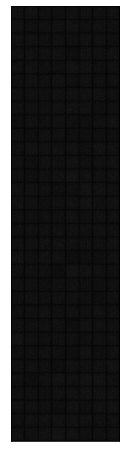

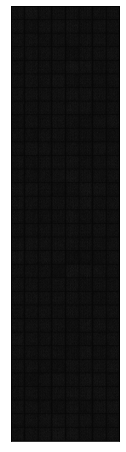

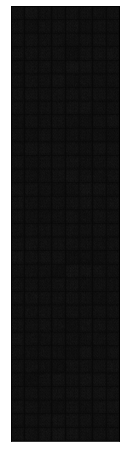

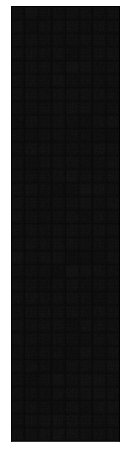

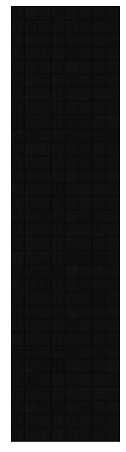

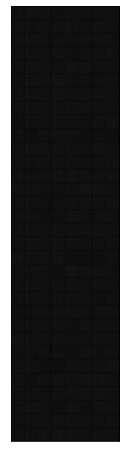

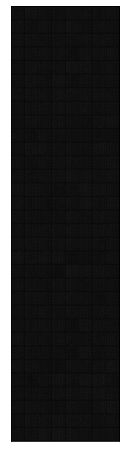

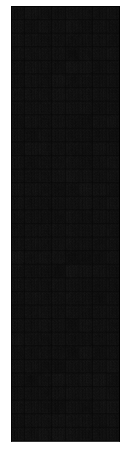

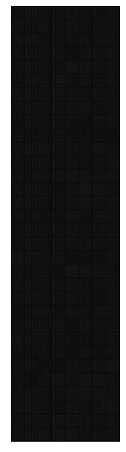

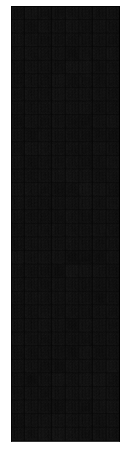

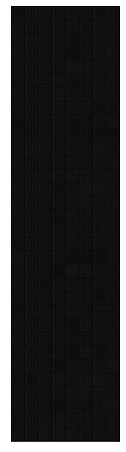

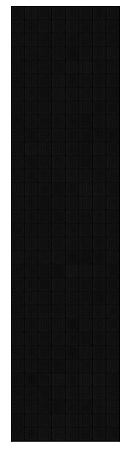

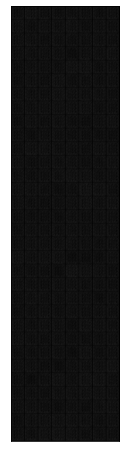

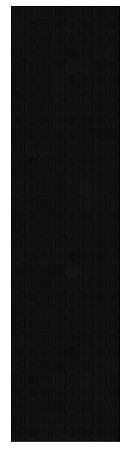

In [62]:
lr = 5e-4
epochs = 7

history = fit(epochs, lr)
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
print(os.listdir('generated/'))
from IPython.display import Image
Image('generated/generated-{:04d}.png'.format(epochs))



In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt. legend(['Discriminator', 'Generator'])
plt.title('Losses')

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend('Real', 'Fake')
plt.title('Scores')